In [1]:
function round_odd(N)
   val=Int64(round(N))
    if (val%2)==0     
     if (N-val)>=0
        val+=1
     else
        val-=1
    end
    end
   return val     
end

function round_even(N)
   val=Int64(round(N))
    if (val%2)==1    
     if (N-val)>0
        val+=1
     else
        val-=1 
     end
    end
   return val     
end

round_even (generic function with 1 method)

In [2]:
round_odd(600/2)

301

# Kitaev-Gamma Chain (Arxiv:1910.14304)

## $$\displaystyle \widetilde{H}(\Phi)= \sum_{\; \; \langle i,j \rangle \\ \in \, \gamma  \text{ bond }} -\sin\Phi \;S_{i}^{\gamma} S_{j}^{\gamma}- \cos\Phi\;(S_{i}^{\alpha} S_{j}^{\alpha}+S_{i}^{\beta} S_{j}^{\beta}),$$ 
###  where $\alpha,\beta \neq \gamma$.

## Symmetry Element $\langle ...XXXX...\rangle$ and $\langle \ldots ZZZZ \ldots \rangle$

In [2]:


using ITensors

function KitaevSymmetryX(T::MPS,start,finish)
    
        mps=copy(T)
        new=copy(T)
        
        for o = (start):1:(finish)
               s = siteind(mps,o)
               newpsi= 2*op(s,"Sx")*mps[o]
               noprime!(newpsi)
               mps[o]= newpsi
        end
            expectation=inner(mps,new)
        return expectation 
end

using ITensors

function KitaevSymmetryZ(T::MPS,start,finish)
    
        mps=copy(T)
        new=copy(T)
        
        for o = (start):1:(finish)
               s = siteind(mps,o)
               newpsi= 2*op(s,"Sz")*mps[o]
               noprime!(newpsi)
               mps[o]= newpsi
        end
        expectation=inner(mps,new)
        return expectation 
end

KitaevSymmetryZ (generic function with 1 method)

In [3]:
using ITensors

    N=600
    acc=1E-10
    bond_dim=50
    sites = siteinds("S=1/2",N)
    psi0 = randomMPS(sites,bond_dim)
    D_length=101
    SOPX_odd_bulk=Array{Float64,1}(undef,D_length)
    SOPZ_odd_bulk=Array{Float64,1}(undef,D_length)
    SOPX_even_bulk=Array{Float64,1}(undef,D_length)
    SOPZ_even_bulk=Array{Float64,1}(undef,D_length)
    SOPX_odd_end=Array{Float64,1}(undef,D_length)
    SOPZ_odd_end=Array{Float64,1}(undef,D_length)
    SOPX_even_end=Array{Float64,1}(undef,D_length)
    SOPZ_even_end=Array{Float64,1}(undef,D_length)
    D_store=Array{Float64,1}(undef,D_length)
    sweep=0.15
    phi=-sweep*pi
    cs=cos(phi)
    ss=sin(phi)
    count=0
    
    for D in LinRange(-1, 1, D_length)
        count+=1
        g1=1.0; g2=g1*10.0^D;
        g=Array{Float64,1}(undef,N-1)
        for i=1:length(g)

            if i%2==1
                g[i]=g2;
            else
                g[i]=g1;
            end
        end
        ampo = AutoMPO()
        for j=1:3:N
            ampo += -4*ss*g[j],"Sy",j,"Sy",j+1;
            ampo += -4*cs*g[j],"Sz",j,"Sz",j+1;
            ampo += -4*cs*g[j],"Sx",j,"Sx",j+1;
        end
        for j=2:3:N
            ampo += -4*ss*g[j],"Sx",j,"Sx",j+1;
            ampo += -4*cs*g[j],"Sy",j,"Sy",j+1;
            ampo += -4*cs*g[j],"Sz",j,"Sz",j+1;
        end
        for j=3:3:N-1
            ampo += -4*ss*g[j],"Sz",j,"Sz",j+1;
            ampo += -4*cs*g[j],"Sx",j,"Sx",j+1;
            ampo += -4*cs*g[j],"Sy",j,"Sy",j+1;
        end
        H = MPO(ampo,sites)
        sweeps = Sweeps(15) # number of sweeps is 15
        maxdim!(sweeps,10,20,50,100,200,400,500,600,700) # gradually increase states kept
        cutoff!(sweeps,acc) # desired truncation error
        E0,Kita = dmrg(H,psi0,sweeps,outputlevel=0)#Run the dmrg algorithm
        @show SOPX_odd_end[count]=real(KitaevSymmetryX(Kita,round_even(N/2),N-1))
        @show SOPZ_odd_end[count]=real(KitaevSymmetryZ(Kita,round_even(N/2),N-1))
        @show SOPX_even_end[count]=real(KitaevSymmetryX(Kita,round_odd(N/2),N))
        @show SOPZ_even_end[count]=real(KitaevSymmetryZ(Kita,round_odd(N/2),N))
        SOPX_odd_bulk[count]=real(KitaevSymmetryX(Kita,round_even(N/4),round_odd(3N/4)))
        SOPZ_odd_bulk[count]=real(KitaevSymmetryZ(Kita,round_even(N/4),round_odd(3N/4)))
        SOPX_even_bulk[count]=real(KitaevSymmetryX(Kita,round_odd(N/4),round_even(3N/4)))
        SOPZ_even_bulk[count]=real(KitaevSymmetryZ(Kita,round_odd(N/4),round_even(3N/4)))
        @show D_store[count]= D
    
    end
   
    using DelimitedFiles
        writedlm("y_end_SOPX_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_odd_bulk,',')
        writedlm("y_end_SOPZ_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_odd_bulk,',')
        writedlm("y_end_SOPX_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_even_bulk,',')
        writedlm("y_end_SOPZ_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_even_bulk,',')
        writedlm("y_end_SOPX_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_odd_end,',')
        writedlm("y_end_SOPZ_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_odd_end,',')
        writedlm("y_end_SOPX_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPX_even_end,',')
        writedlm("y_end_SOPZ_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",SOPZ_even_end,',')        

SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.995493218017144
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.9973698466832595
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = -7.099422723523831e-15
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = -1.0529254310655475e-13
D_store[count] = D = -1.0
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.995044862574013
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.9971014734157411
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 5.485657853340437e-15
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 2.5769884715830184e-14
D_store[count] = D = -0.98
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9945511780944072
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) 

D_store[count] = D = -0.6200000000000001
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9688971519574968
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.9803987936278331
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 8.952027871085012e-15
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 1.0477681913448472e-13
D_store[count] = D = -0.6000000000000001
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9656507817013703
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.9782182779656491
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = -2.579685281032193e-14
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 9.58082325413911e-14
D_store[count] = D = -0.5800000000000001
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.9620517936285105
SOPZ_od

SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 5.4575773368884464e-14
D_store[count] = D = -0.21999999999999997
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.7490969599642154
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.8052865241347511
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 5.383773235304999e-16
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 3.408338890489573e-14
D_store[count] = D = -0.19999999999999996
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 0.7189199125238402
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 0.7780997632748208
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = -2.085930719890683e-10
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 4.604145903965749e-10
D_store[count] = D = -0.1800000000000001
SOPX_

SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9411129948092457
D_store[count] = D = 0.15999999999999992
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 1.4688921296814944e-19
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 1.7073628571719223e-19
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 0.9594495781931442
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9481340243607058
D_store[count] = D = 0.17999999999999994
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 3.426795505186029e-27
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 3.2443573843851893e-26
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 0.9644063453099608
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9541216906653402
D_store[count] = D = 0.19999999999999996
SOPX_odd_

SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9931460500737308
D_store[count] = D = 0.56
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = 2.5883360907258425e-27
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 5.2900656333139015e-27
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 0.9955644737301969
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9937857332328027
D_store[count] = D = 0.5800000000000001
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = -9.330065211541985e-28
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = -1.203099044191907e-28
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 0.9959870211492501
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9943635943482335
D_store[count] = D = 0.6000000000000001
SOPX_odd_end[count] = rea

D_store[count] = D = 0.96
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = -1.4504576889443043e-29
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 1.0129476966911926e-26
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 0.9993632197852313
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9990776169004496
D_store[count] = D = 0.98
SOPX_odd_end[count] = real(KitaevSymmetryX(Kita, round_even(N / 2), N - 1)) = -1.1724072730412694e-29
SOPZ_odd_end[count] = real(KitaevSymmetryZ(Kita, round_even(N / 2), N - 1)) = 3.9484408088535543e-28
SOPX_even_end[count] = real(KitaevSymmetryX(Kita, round_odd(N / 2), N)) = 0.9994208173522101
SOPZ_even_end[count] = real(KitaevSymmetryZ(Kita, round_odd(N / 2), N)) = 0.9991602193002939
D_store[count] = D = 1.0


In [1]:
N=600
sweep=0.15
D_length=101
acc=1E-10
using DelimitedFiles
SOPX_odd_end=readdlm("y_end_SOPX_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_odd_end=readdlm("y_end_SOPZ_end_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPX_even_end=readdlm("y_end_SOPX_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_even_end=readdlm("y_end_SOPZ_end_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
D_store=LinRange(-1,1,D_length)
SOPX_odd_bulk=readdlm("y_end_SOPX_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_odd_bulk=readdlm("y_end_SOPZ_bulk_odd_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPX_even_bulk=readdlm("y_end_SOPX_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',')
SOPZ_even_bulk=readdlm("y_end_SOPZ_bulk_even_DimerisedKG_phi=$sweep points=$D_length N=$N accuracy= $acc.csv",',');

101×1 Matrix{Float64}:
 -1.037440035557759e-26
 -9.433225358296323e-27
  2.0383447892363687e-27
 -7.036594413851243e-27
 -6.270753517075535e-27
  3.8015929327416284e-28
  4.281997700361114e-21
 -7.924871496043344e-21
 -2.489797766892023e-27
 -3.170024797606011e-27
 -8.113413361571433e-27
 -2.3787876103703408e-27
 -4.510834631463021e-28
  ⋮
  0.9952617972389609
  0.9956911021045455
  0.9960808979388365
  0.9964349099802672
  0.9967564948051312
  0.9970486952746491
  0.9973142517006707
  0.9975556294746756
  0.9977750752181367
  0.9979746154568133
  0.9981560845914482
  0.998321143832193

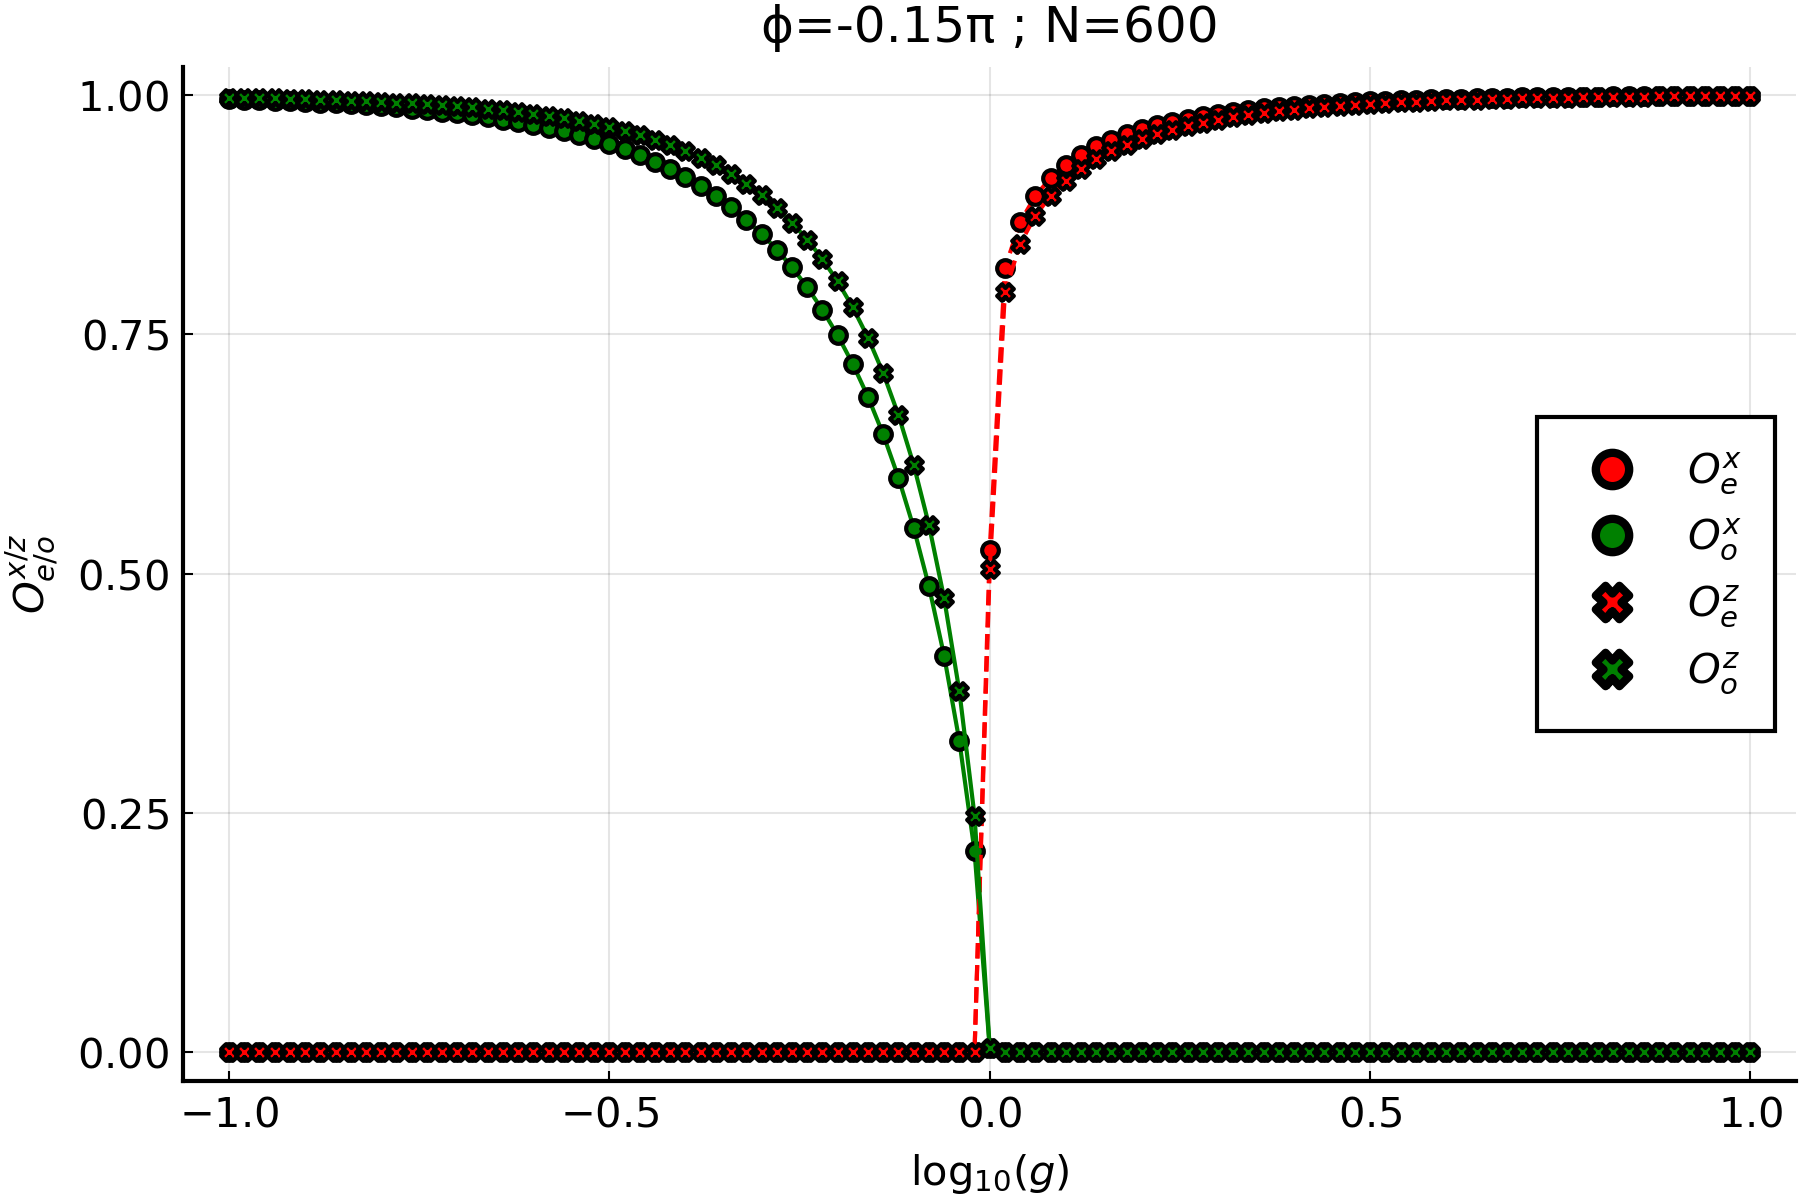

In [23]:
using Plots
using LaTeXStrings
pyplot()
    p1= plot(D_store,SOPX_even_end,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPX_even_end,label=L"O_{e}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:red)
    plot!(D_store,SOPX_odd_end,label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,SOPX_odd_end,label=L"O_{o}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:green)
    plot!(D_store,SOPZ_even_end,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPZ_even_end,label=L"O_{e}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:red)
    plot!(D_store,SOPZ_odd_end,label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,SOPZ_odd_end,label=L"O_{o}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:green)
    xlabel!(L"\log_{10}(g)")
    ylabel!(L"O_{e/o}^{x/z}")
    #png("y_end_SOPX_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")

In [8]:
png("y_end_SOP_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")

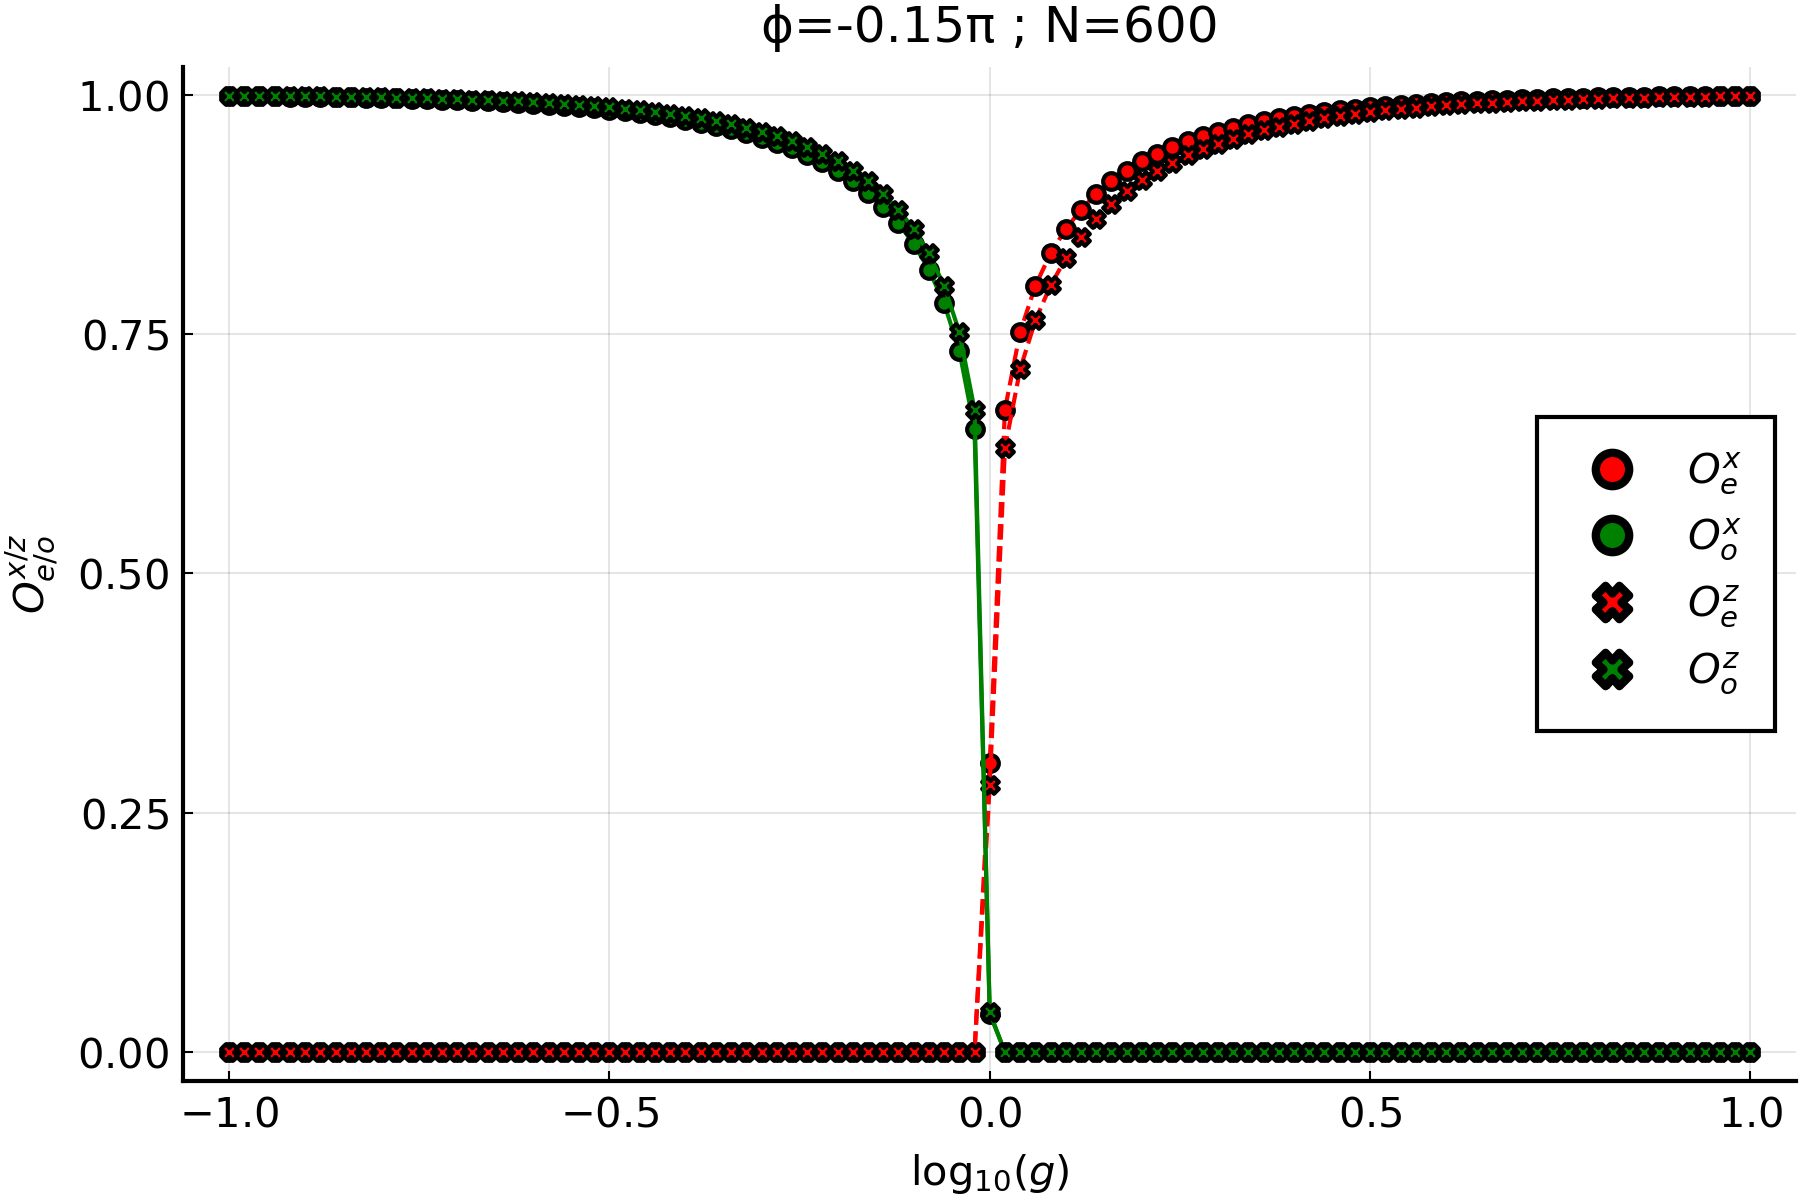

In [26]:
using Plots
using LaTeXStrings
pyplot()
    p1= plot(D_store,SOPX_even_bulk,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPX_even_bulk,label=L"O_{e}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:red)
    plot!(D_store,SOPX_odd_bulk,label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,SOPX_odd_bulk,label=L"O_{o}^{x}",legend=:right,dpi=300,markersize=4,reuse=false,markercolor=:green)
    plot!(D_store,SOPZ_even_bulk,title ="ϕ=-0.15π ; N=$N",label=false,legend=:top,fmt = :png,linestyle=:dash,dpi=300,reuse=false,linecolor=:red,xguidefontsize=10,yguidefontsize=10,legendfontsize=10,xtickfontsize=10,ytickfontsize=10,titlefontsize=12) 
    scatter!(D_store,SOPZ_even_bulk,label=L"O_{e}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:red)
    plot!(D_store,abs.SOPZ_odd_bulk,label=false,legend=:top,fmt=:png,linestyle=:solid,dpi=300,reuse=false,linecolor=:green)
    scatter!(D_store,abs.(SOPZ_odd_bulk),label=L"O_{o}^{z}",legend=:right,dpi=300,markersize=4,markershape=:xcross,reuse=false,markercolor=:green)
    xlabel!(L"\log_{10}(g)")
    ylabel!(L"O_{e/o}^{x/z}")
    #png("y_end_SOPX_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")

In [10]:
png("y_end_SOPX_bulk_DimerisedKG_phi=-$sweep π points=$D_length N=$N accuracy= $acc")